# Imports

In [1]:
import os 
os.chdir("/home/ivanr/git/document_information_extraction/")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from src.data.wikipedia.wiki_data_base import retrieve_query

#  Constants

In [4]:
plt.rcParams["figure.figsize"] = (12.5,7.5)

# Read data

In [5]:
query =f"""
SELECT *
FROM article_level_info
WHERE body_word_count>15 and summary_word_count>150
"""

data = retrieve_query(query)

In [6]:
data = pd.DataFrame(
    data,
    columns=["pageid", "title", "summary_word_count", "body_word_count"],
)

In [7]:
print(f"Number of observations: {len(data)}")

Number of observations: 31000


# Evaluate distribution

In [8]:
data.head()

,pageid,title,summary_word_count,body_word_count
0,10,AccessibleComputing,3,0
1,12,Anarchism,357,6995
2,13,AfghanistanHistory,4,0
3,14,AfghanistanGeography,4,0
4,15,AfghanistanPeople,4,0


In [9]:
data.min()

pageid                                     10
title                 "Hello, World!" program
summary_word_count                          0
body_word_count                             0
dtype: object

In [10]:
data.max()

pageid                      46645
title                 ♯P-complete
summary_word_count           4712
body_word_count             39171
dtype: object

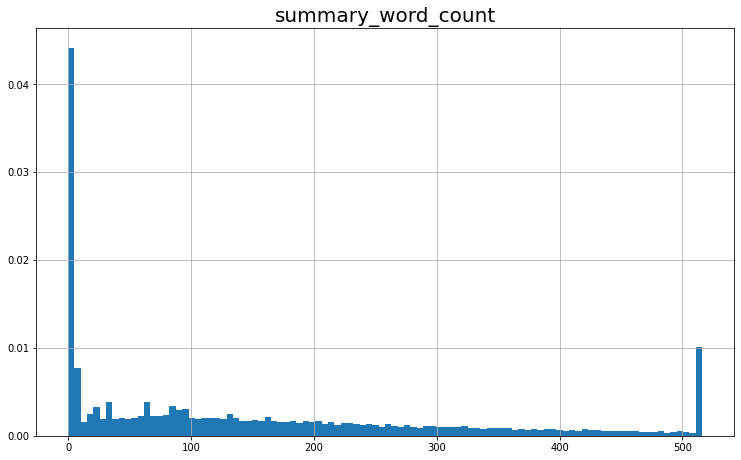

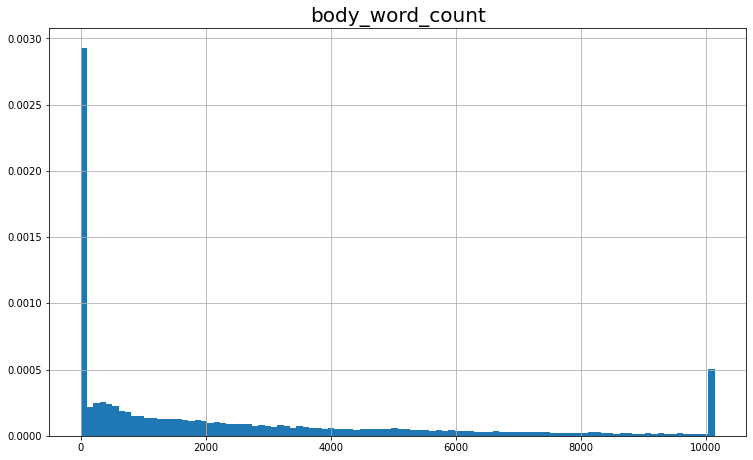

In [11]:
for var in [ "summary_word_count", "body_word_count"]:
    plt.figure(figsize = (12.5,7.5))
    plt.title(var, fontsize = 20)
    quantile = data[var].quantile(.95)
    data[var].clip(0,quantile).hist(bins = int(min(100,quantile)), density = True)
    plt.show()
    

# Ratios

In [12]:
data["tokens_ratio_summary_body"]=data["summary_word_count"]/data["body_word_count"]

ValueError: supplied range of [0.0, inf] is not finite

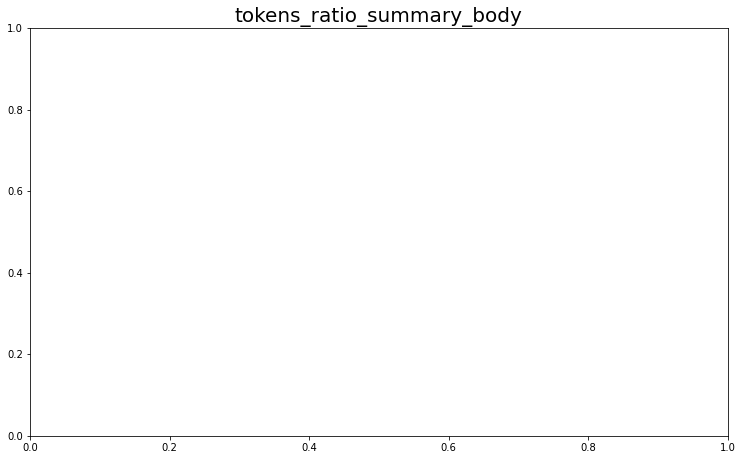

In [13]:
for var in ["tokens_ratio_summary_body"]:
    plt.figure(figsize = (12.5,7.5))
    plt.title(var, fontsize = 20)
    quantile = data[var].quantile(.90)
    data[var].clip(0,quantile).hist(bins = 100, density = True)
    plt.show()
    

# Joint plots

In [ ]:
cols_to_clip = ["tokens_ratio_summary_body","summary_word_count","body_word_count"]
for var in cols_to_clip :
    quantile = data[var].quantile(0.90)
    data[var + "_clip"] = data[var].clip(0, quantile)
    

In [ ]:
import matplotlib.cm as cm
from matplotlib.colors import LogNorm


def plot_joint(data, x_label, y_label, bins=(100, 100)):

    x = data[x_label]
    y = data[y_label]

    ax1 = sns.jointplot(x=x, y=y)
    ax1.ax_joint.cla()
    plt.sca(ax1.ax_joint)

    plt.hist2d(x, y, bins=bins, cmap=cm.jet, norm=LogNorm())
    plt.xlabel(x_label, fontsize=13)
    plt.ylabel(y_label, fontsize=13)

    cbar_ax = ax1.fig.add_axes([1, 0.1, 0.03, 0.7])
    cb = plt.colorbar(cax=cbar_ax)
    cb.set_label(r"$\log_{10}$ density of points", fontsize=13)
    
    plt.show()

In [ ]:
plot_joint(
    data,
    "summary_word_count",
    "body_word_count",
    bins=(100, 100),
)

In [ ]:
query =f"""
SELECT ar.*, wk.*
FROM article_level_info ar
LEFT JOIN wiki_articles wk 
    ON ar.pageid = wk.pageid
WHERE ar.body_word_count>15 and ar.summary_word_count>150
LIMIT 50
"""

data_text = retrieve_query(query)

In [ ]:
for i in data_text:
    print("-"*100)
    for j in i:
        print(j)